In [1]:
"""
Phase 2: Severity Label Analysis and Validation
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("BugSage Label Analysis")
print("=" * 60)

BugSage Label Analysis


In [2]:
# Load labeled data
current_dir = Path.cwd()

possible_paths = [
    current_dir / 'data' / 'interim' / 'salt_commits_labeled.csv',
    current_dir / '..' / 'data' / 'interim' / 'salt_commits_labeled.csv',
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError("Could not find salt_commits_labeled.csv")

print(f"Loading data from: {data_path}")

df = pd.read_csv(data_path)
df['commit_time'] = pd.to_datetime(df['commit_time'])

print(f"\nLoaded {len(df):,} records")
print(f"Shape: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading data from: E:\Projects\bug-sev-diss\notebooks\..\data\interim\salt_commits_labeled.csv

Loaded 6,620 records
Shape: (6620, 19)
Memory: 56.72 MB



Severity Distribution:
  HIGH    :   305 ( 4.61%)
  MEDIUM  :  5412 (81.75%)
  LOW     :   903 (13.64%)

Confidence Statistics:
  Mean: 0.415
  Median: 0.400
  Min: 0.200
  Max: 0.725


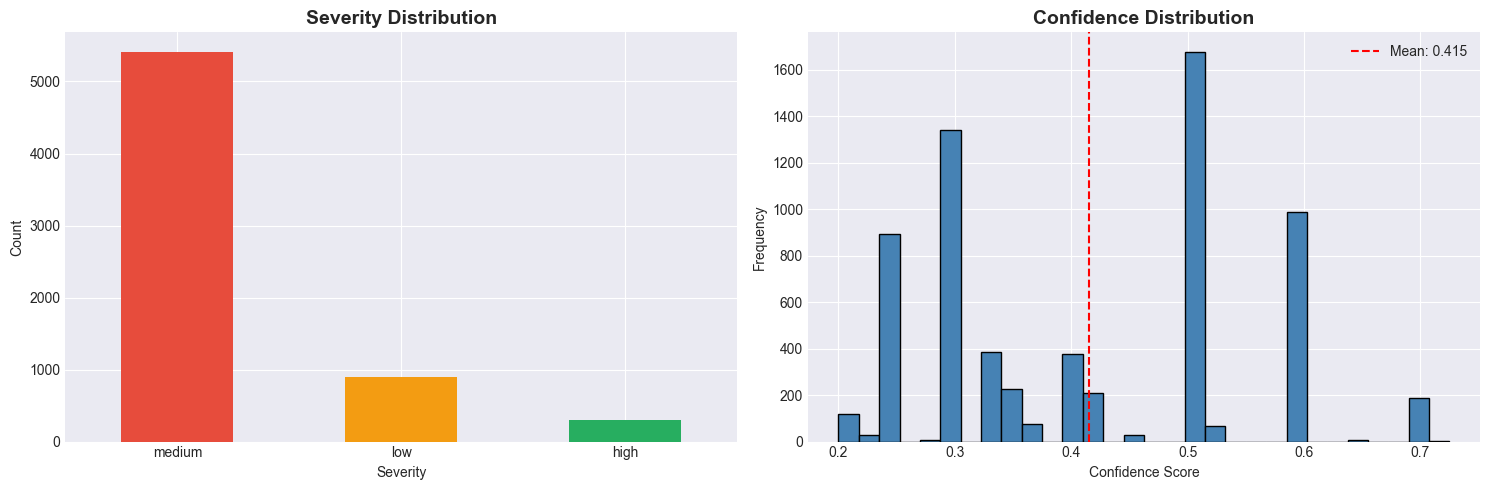

In [3]:
# Overall distribution
print("\nSeverity Distribution:")
severity_counts = df['severity_label'].value_counts()

for severity in ['high', 'medium', 'low']:
    count = severity_counts.get(severity, 0)
    pct = count / len(df) * 100
    print(f"  {severity.upper():8s}: {count:5d} ({pct:5.2f}%)")

# Confidence analysis
print(f"\nConfidence Statistics:")
print(f"  Mean: {df['severity_confidence'].mean():.3f}")
print(f"  Median: {df['severity_confidence'].median():.3f}")
print(f"  Min: {df['severity_confidence'].min():.3f}")
print(f"  Max: {df['severity_confidence'].max():.3f}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Severity distribution
severity_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#f39c12', '#27ae60'])
ax1.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Confidence distribution
df['severity_confidence'].hist(bins=30, ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.axvline(df['severity_confidence'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["severity_confidence"].mean():.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

In [4]:
# Show examples of each severity

print("\n" + "=" * 70)
print("HIGH SEVERITY EXAMPLES")
print("=" * 70)

high_samples = df[df['severity_label'] == 'high'].head(5)
for idx, row in high_samples.iterrows():
    print(f"\nCommit: {row['commit_sha'][:8]}")
    print(f"File: {row['file_path']}")
    print(f"Message: {row['message'][:80]}...")
    print(f"Confidence: {row['severity_confidence']:.3f}")
    print(f"Reasons: {row['severity_reasons']}")
    print(f"Changes: +{row['insertions']} -{row['deletions']}")

print("\n" + "=" * 70)
print("MEDIUM SEVERITY EXAMPLES")
print("=" * 70)

medium_samples = df[df['severity_label'] == 'medium'].head(5)
for idx, row in medium_samples.iterrows():
    print(f"\nCommit: {row['commit_sha'][:8]}")
    print(f"File: {row['file_path']}")
    print(f"Message: {row['message'][:80]}...")
    print(f"Confidence: {row['severity_confidence']:.3f}")
    print(f"Reasons: {row['severity_reasons']}")

print("\n" + "=" * 70)
print("LOW SEVERITY EXAMPLES")
print("=" * 70)

low_samples = df[df['severity_label'] == 'low'].head(5)
for idx, row in low_samples.iterrows():
    print(f"\nCommit: {row['commit_sha'][:8]}")
    print(f"File: {row['file_path']}")
    print(f"Message: {row['message'][:80]}...")
    print(f"Confidence: {row['severity_confidence']:.3f}")
    print(f"Reasons: {row['severity_reasons']}")


HIGH SEVERITY EXAMPLES

Commit: 58702989
File: salt/transport/zeromq.py
Message: Hold on to send/recv socket reference.

Grab a reference to the send/recv socket...
Confidence: 0.600
Reasons: critical_file:transport/zeromq
Changes: +11 -4

Commit: d7cf64f8
File: salt/transport/zeromq.py
Message: Use a tornado queue to reduce wait times in send recieve method...
Confidence: 0.600
Reasons: critical_file:transport/zeromq
Changes: +13 -7

Commit: 145a06e7
File: salt/transport/zeromq.py
Message: Refactor send recv to avoid race conditions and limit memory usage...
Confidence: 0.600
Reasons: critical_file:transport/zeromq
Changes: +53 -60

Commit: fd3a7bf1
File: salt/transport/tcp.py
Message: Add changelog for #67076...
Confidence: 0.600
Reasons: critical_file:transport/tcp
Changes: +9 -4

Commit: 85db07aa
File: salt/crypt.py
Message: Standardize auth singleton key...
Confidence: 0.600
Reasons: critical_file:crypt
Changes: +15 -15

MEDIUM SEVERITY EXAMPLES

Commit: fe49c7cf
File: salt/modul

In [5]:
# Analyze severity by file path patterns

print("\nSeverity by File Path:")

# Extract directory
df['directory'] = df['file_path'].apply(lambda x: x.split('/')[0] if '/' in x else 'root')

# Top directories
top_dirs = df['directory'].value_counts().head(10).index

for directory in top_dirs:
    dir_df = df[df['directory'] == directory]
    severity_dist = dir_df['severity_label'].value_counts(normalize=True) * 100
    
    print(f"\n  {directory}/ ({len(dir_df)} files):")
    for sev in ['high', 'medium', 'low']:
        pct = severity_dist.get(sev, 0)
        print(f"    {sev:8s}: {pct:5.1f}%")


Severity by File Path:

  salt/ (4997 files):
    high    :   4.5%
    medium  :  86.4%
    low     :   9.1%

  tools/ (527 files):
    high    :   2.3%
    medium  :  67.0%
    low     :  30.7%

  requirements/ (473 files):
    high    :  13.1%
    medium  :  78.9%
    low     :   8.0%

  root/ (263 files):
    high    :   1.1%
    medium  :  73.8%
    low     :  25.1%

  changelog/ (250 files):
    high    :   0.0%
    medium  :  35.6%
    low     :  64.4%

  pkg/ (53 files):
    high    :   0.0%
    medium  :  96.2%
    low     :   3.8%

  tasks/ (33 files):
    high    :   0.0%
    medium  :  63.6%
    low     :  36.4%

  cicd/ (8 files):
    high    :   0.0%
    medium  :  87.5%
    low     :  12.5%

  conf/ (5 files):
    high    :   0.0%
    medium  : 100.0%
    low     :   0.0%

  .ci/ (5 files):
    high    :  80.0%
    medium  :  20.0%
    low     :   0.0%


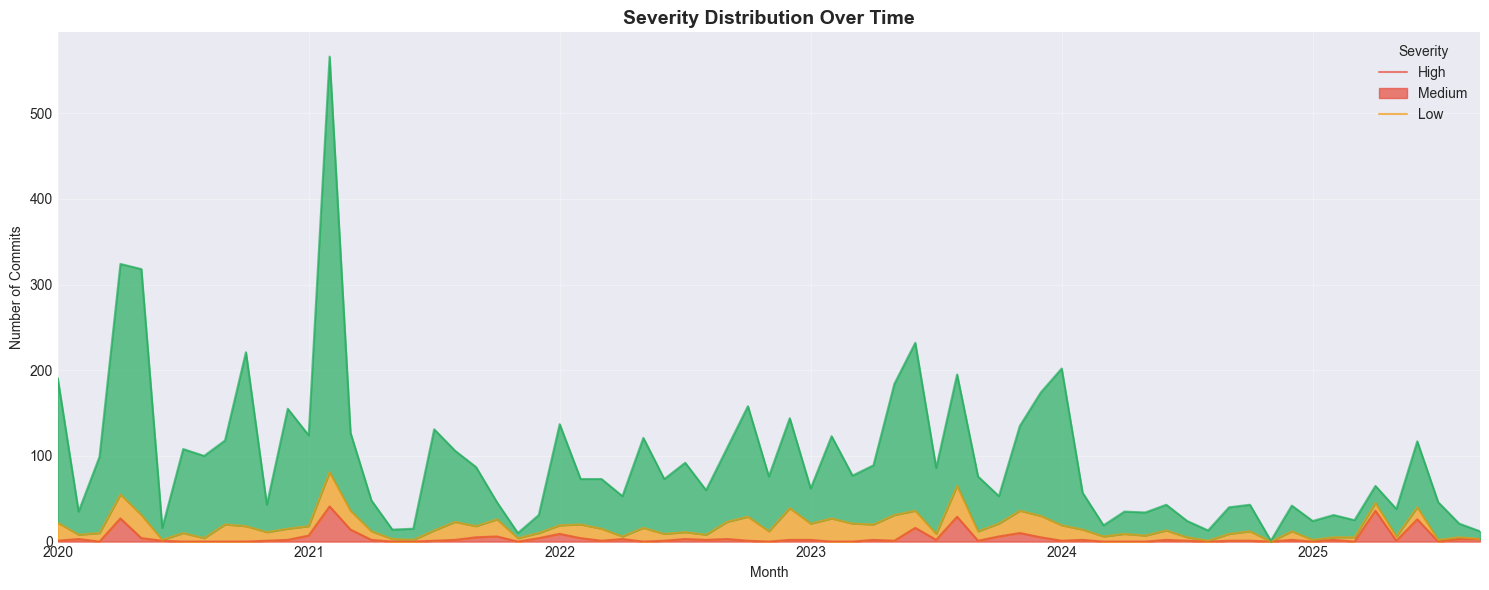

In [6]:
# Severity over time

df['year_month'] = df['commit_time'].dt.to_period('M')

severity_by_month = df.groupby(['year_month', 'severity_label']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(15, 6))

severity_by_month.plot(kind='area', stacked=True, ax=ax, 
                        color=['#e74c3c', '#f39c12', '#27ae60'],
                        alpha=0.7)

ax.set_title('Severity Distribution Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Commits')
ax.legend(title='Severity', labels=['High', 'Medium', 'Low'])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
print("\n" + "=" * 70)
print("LABEL QUALITY ASSESSMENT")
print("=" * 70)

# Check label distribution
high_pct = (df['severity_label'] == 'high').sum() / len(df) * 100
medium_pct = (df['severity_label'] == 'medium').sum() / len(df) * 100
low_pct = (df['severity_label'] == 'low').sum() / len(df) * 100

print(f"\nLabel Distribution:")
print(f"  High: {high_pct:.1f}%")
print(f"  Medium: {medium_pct:.1f}%")
print(f"  Low: {low_pct:.1f}%")

# Assessment
print(f"\nAssessment:")
if medium_pct > 70:
    print("  - Medium class is dominant (>70%)")
    print("  - Consider adjusting thresholds to increase high/low")
else:
    print("  - Distribution is reasonable")

if high_pct < 10:
    print(f"  - High severity is rare ({high_pct:.1f}%)")
    print("  - This may be realistic for the dataset")
else:
    print(f"  - High severity represents {high_pct:.1f}% of data")

avg_conf = df['severity_confidence'].mean()
if avg_conf < 0.5:
    print(f"  - Average confidence is low ({avg_conf:.3f})")
    print("  - Labels may need refinement")
else:
    print(f"  - Average confidence is moderate ({avg_conf:.3f})")

print(f"\nDataset ready for training:")
print(f"  Total labeled records: {len(df):,}")
print(f"  High severity: {(df['severity_label'] == 'high').sum():,}")
print(f"  Medium severity: {(df['severity_label'] == 'medium').sum():,}")
print(f"  Low severity: {(df['severity_label'] == 'low').sum():,}")


LABEL QUALITY ASSESSMENT

Label Distribution:
  High: 4.6%
  Medium: 81.8%
  Low: 13.6%

Assessment:
  - Medium class is dominant (>70%)
  - Consider adjusting thresholds to increase high/low
  - High severity is rare (4.6%)
  - This may be realistic for the dataset
  - Average confidence is low (0.415)
  - Labels may need refinement

Dataset ready for training:
  Total labeled records: 6,620
  High severity: 305
  Medium severity: 5,412
  Low severity: 903
